**Practical 11 - Transfer Learning**

Name : Nimna Alupotha Gamage (NIMNA A. G. T.) - Index No.: s14682 - Reg. No. : 2019s17241 - Faculty :
Science

Exercise on transfer learning for images with Keras

Getting the dataset

- Download the dataset into Colab’s virtual machine

In [1]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \-O /content/catsdogs.zip

--2023-08-23 12:29:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/catsdogs.zip’

/content/catsdogs.z 100%[===================>]  65.43M  98.6MB/s    in 0.7s    

2023-08-23 12:29:17 (98.6 MB/s) - ‘/content/catsdogs.zip’ saved [68606236/68606236]



- Unzip the dataset and set the path to the training and validation set

In [2]:
import os
import zipfile
with zipfile.ZipFile('catsdogs.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')
base_dir = '/content/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

Loading the dataset from a directory

- Import the required modules and load the training and validation set

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir, shuffle=True, batch_size=32, image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=32, image_size=(150, 150))


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Data pre-processing

- Augment by introducing unique layers

In [4]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

These layers will only be applied during the training process

-  Applying the layers to the same
image to see the result of the above transformations

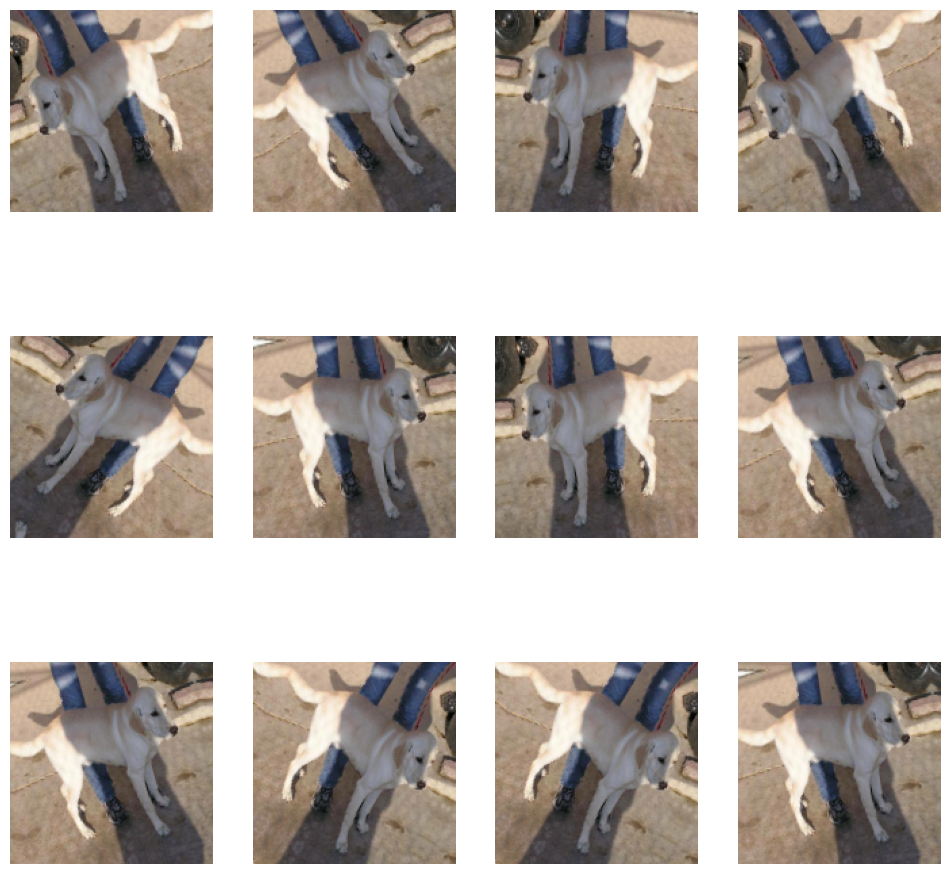

In [5]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
  plt.figure(figsize=(12, 12))
  first_image = images[0]
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image, 0)
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

Create a base model from the pre-trained Xception model

- load the model with the weights trained on ImageNet to define the desired
input shape

In [6]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

83683744/83683744 [==============================] - 2s 0us/step


- Freeze the base model layers (Therefore, they’re not updated during the training process.)

In [7]:
base_model.trainable = False

Create the final dense layer - define a final output layer for this
model

- Standardizing the size of the input images

In [8]:
inputs = keras.Input(shape=(150, 150, 3))

- Apply the data augmentation

In [9]:
x = data_augmentation(inputs)

-  Process the data (This model expects data in the range of (-1,1) and not (0,1))

In [10]:
x = tf.keras.applications.xception.preprocess_input(x)

- Define the model

In [11]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Train the model

- Train the top layer

In [12]:
model.compile(optimizer='adam',
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras
.metrics.BinaryAccuracy())
model.fit(training_set, epochs=20, validation_data=val_dataset)

Epoch 1/20
63/63 [==============================] - 326s 5s/step - loss: 0.3056 - binary_accuracy: 0.8510 - val_loss: 0.1099 - val_binary_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 320s 5s/step - loss: 0.1474 - binary_accuracy: 0.9395 - val_loss: 0.0899 - val_binary_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 320s 5s/step - loss: 0.1300 - binary_accuracy: 0.9495 - val_loss: 0.0840 - val_binary_accuracy: 0.9690
Epoch 4/20
63/63 [==============================] - 317s 5s/step - loss: 0.1242 - binary_accuracy: 0.9505 - val_loss: 0.0821 - val_binary_accuracy: 0.9670
Epoch 5/20
63/63 [==============================] - 318s 5s/step - loss: 0.1093 - binary_accuracy: 0.9500 - val_loss: 0.0759 - val_binary_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 319s 5s/step - loss: 0.1050 - binary_accuracy: 0.9645 - val_loss: 0.0728 - val_binary_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 318s 5s/step - los

The obtained validation accuracy is 0.9700 (97%)

Fine-tuning the model

- Unfreezing the base model, and retraining it on a very low learning rate


In [13]:
# Unfreze some layers from the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tuning layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),  # Use a very low learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Fine-tune the model
model.fit(training_set, epochs=5, validation_data=val_dataset)

Epoch 1/5
63/63 [==============================] - 459s 7s/step - loss: 0.3920 - binary_accuracy: 0.9120 - val_loss: 0.1105 - val_binary_accuracy: 0.9430
Epoch 2/5
63/63 [==============================] - 449s 7s/step - loss: 0.1314 - binary_accuracy: 0.9530 - val_loss: 0.1071 - val_binary_accuracy: 0.9690
Epoch 3/5
63/63 [==============================] - 449s 7s/step - loss: 0.1258 - binary_accuracy: 0.9615 - val_loss: 0.0960 - val_binary_accuracy: 0.9820
Epoch 4/5
63/63 [==============================] - 390s 6s/step - loss: 0.0903 - binary_accuracy: 0.9660 - val_loss: 0.0894 - val_binary_accuracy: 0.9790
Epoch 5/5
63/63 [==============================] - 447s 7s/step - loss: 0.0804 - binary_accuracy: 0.9680 - val_loss: 0.0850 - val_binary_accuracy: 0.9770


The obtained validation accuracy after fine-tuning is 0.9770 (98%)